# FFNN using numpy

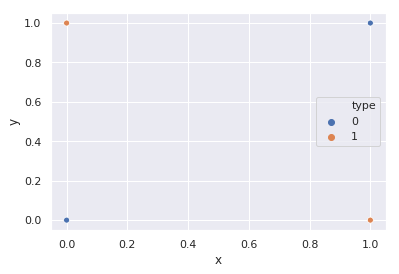

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.metrics import roc_auc_score

# Creating the data

# initiating random number
np.random.seed(11)

data_xor = pd.DataFrame({'x': [0, 1, 0, 1], 'y':[0, 0, 1, 1], 'type': ['0', '1', '1', '0']})

ax = sns.scatterplot(x="x", y="y", hue="type",
                      data=data_xor)


In [3]:
data_xor.pivot(index='x', columns='y')

type   
y    0  1
x        
0    0  1
1    1  0

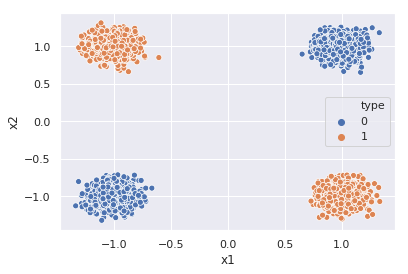

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib

matplotlib.use("TkAgg")

# initiating random number
np.random.seed(11)

#### Creating the dataset

# mean and standard deviation for the x belonging to the first class
mu_x1, sigma_x1 = 0, 0.1

# constat to make the second distribution different from the first
# x1_mu_diff, x2_mu_diff, x3_mu_diff, x4_mu_diff = 0.5, 0.5, 0.5, 0.5
x1_mu_diff, x2_mu_diff, x3_mu_diff, x4_mu_diff = 0, 1, 0, 1

# creating the first distribution
d1 = pd.DataFrame({'x1': np.random.normal(mu_x1, sigma_x1, 1000) + 1,
                   'x2': np.random.normal(mu_x1, sigma_x1, 1000) + 1,
                   'type': 0})

d2 = pd.DataFrame({'x1': np.random.normal(mu_x1, sigma_x1, 1000) + 1,
                   'x2': np.random.normal(mu_x1, sigma_x1, 1000) - 1,
                   'type': 1})

d3 = pd.DataFrame({'x1': np.random.normal(mu_x1, sigma_x1, 1000) - 1,
                   'x2': np.random.normal(mu_x1, sigma_x1, 1000) - 1,
                   'type': 0})

d4 = pd.DataFrame({'x1': np.random.normal(mu_x1, sigma_x1, 1000) - 1,
                   'x2': np.random.normal(mu_x1, sigma_x1, 1000) + 1,
                   'type': 1})

data = pd.concat([d1, d2, d3, d4], ignore_index=True)

ax = sns.scatterplot(x="x1", y="x2", hue="type",
                      data=data)



In [5]:
# Splitting the dataset in training and test set
msk = np.random.rand(len(data)) < 0.8

# Roughly 80% of data will go in the training set
train_x, train_y = data[['x1', 'x2']][msk], data[['type']][msk].values

# Everything else will go into the validation set
test_x, test_y = data[['x1', 'x2']][~msk], data[['type']][~msk].values

In [6]:
def sigmoid(s):
    # Activation function
    return 1 / (1 + np.exp(-s))


def sigmoid_prime(s):
    # Derivative of the sigmoid
    return sigmoid(s) * (1 - sigmoid(s))


class FFNN(object):

    def __init__(self, input_size=2, hidden_size=2, output_size=1):
        # Adding 1 as it will be our bias
        self.input_size = input_size + 1
        self.hidden_size = hidden_size + 1
        self.output_size = output_size

        self.o_error = 0
        self.o_delta = 0
        self.z1 = 0
        self.z2 = 0
        self.z3 = 0
        self.z2_error = 0

        # The whole weight matrix, from the inputs till the hidden layer
        self.w1 = np.random.randn(self.input_size, self.hidden_size)
        # The final set of weights from the hidden layer till the output layer
        self.w2 = np.random.randn(self.hidden_size, self.output_size)

    def forward(self, X):
        # Forward propagation through our network
        X['bias'] = 1  # Adding 1 to the inputs to include the bias in the weight
        self.z1 = np.dot(X, self.w1)  # dot product of X (input) and first set of 3x2 weights
        self.z2 = sigmoid(self.z1)  # activation function
        self.z3 = np.dot(self.z2, self.w2)  # dot product of hidden layer (z2) and second set of 3x1 weights
        o = sigmoid(self.z3)  # final activation function
        return o

    def backward(self, X, y, output, step):
        # Backward propagation of the errors
        X['bias'] = 1  # Adding 1 to the inputs to include the bias in the weight
        self.o_error = y - output  # error in output
        self.o_delta = self.o_error * sigmoid_prime(output) * step  # applying derivative of sigmoid to error

        self.z2_error = self.o_delta.dot(
            self.w2.T)  # z2 error: how much our hidden layer weights contributed to output error
        self.z2_delta = self.z2_error * sigmoid_prime(self.z2) * step  # applying derivative of sigmoid to z2 error

        self.w1 += X.T.dot(self.z2_delta)  # adjusting first of weights
        self.w2 += self.z2.T.dot(self.o_delta)  # adjusting second set of weights

    def predict(self, X):
        return forward(self, X)

    def fit(self, X, y, epochs=10, step=0.05):
        for epoch in range(epochs):
            X['bias'] = 1  # Adding 1 to the inputs to include the bias in the weight
            output = self.forward(X)
            self.backward(X, y, output, step)


In [7]:

my_network = FFNN()

my_network.fit(train_x, train_y, epochs=10000, step=0.001)

pred_y = test_x.apply(my_network.forward, axis=1)

test_y_ = [i[0] for i in test_y]
pred_y_ = [i[0] for i in pred_y]

print('MSE: ', mean_squared_error(test_y_, pred_y_))
print('AUC: ', roc_auc_score(test_y_, pred_y_))

threshold = 0.5
pred_y_binary = [0 if i > threshold else 1 for i in pred_y_]

cm = confusion_matrix(test_y_, pred_y_binary, labels=[0, 1])

print(pd.DataFrame(cm,
                   index=['True 0', 'True 1'],
                   columns=['Predicted 0', 'Predicted 1']))


MSE:  0.14411050529485442
AUC:  1.0
        Predicted 0  Predicted 1
True 0            3          422
True 1          392            0


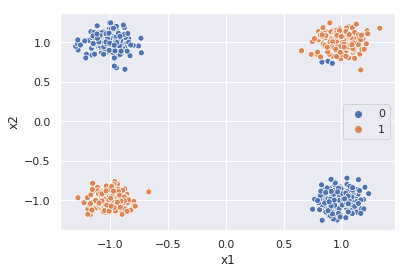

In [8]:
# If we want binary predictions we can do:         
# data['predicted'] = [0 if i > threshold else 1 for i in pred_y]

ax = sns.scatterplot(x="x1", y="x2", hue=pred_y_binary,
                      data=data[~msk])


# FFNN using keras

We will now see hoe it's possible to use Keras to create a simple FFNN.

In [9]:
train_x[['x1', 'x2']]

,x1,x2
0,1.174945,0.927483
2,0.951543,0.898548
3,0.734668,1.051926
4,0.999172,1.130808
5,0.968037,0.904807
6,0.946337,1.213541
8,1.042105,0.779857
9,0.893440,1.142233
10,0.911376,1.194511
11,0.952427,0.976064


In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
import os
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard

model = Sequential()
model.add(Dense(2, input_dim=2))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

sgd = SGD(lr=0.1)
model.compile(loss='mse', optimizer=sgd)

model.fit(train_x[['x1', 'x2']], train_y,batch_size=1, epochs=2)
pred = model.predict_proba(test_x)

print('NSE: ',mean_squared_error(test_y, pred))



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
3183/3183 [==============================] - 4s 1ms/step - loss: 0.0375
Epoch 2/2
3183/3183 [==============================] - 4s 1ms/step - loss: 0.0023
NSE:  0.001560287547671029


In [11]:

basedir = '..'

logs = os.path.join(basedir, 'logs')

tbCallBack = TensorBoard(
    log_dir=logs, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [tbCallBack]

model.fit(train_x[['x1', 'x2']], train_y, batch_size=1, epochs=10, callbacks=callbacks_list)


Epoch 1/10
3183/3183 [==============================] - 5s 1ms/step - loss: 0.0012
Epoch 2/10
3183/3183 [==============================] - 3s 1ms/step - loss: 8.1844e-04
Epoch 3/10
3183/3183 [==============================] - 3s 1ms/step - loss: 6.1899e-04
Epoch 4/10
3183/3183 [==============================] - 4s 1ms/step - loss: 4.9708e-04
Epoch 5/10
3183/3183 [==============================] - 3s 1ms/step - loss: 4.1498e-04
Epoch 6/10
3183/3183 [==============================] - 3s 1ms/step - loss: 3.5596e-04
Epoch 7/10
3183/3183 [==============================] - 3s 1ms/step - loss: 3.1150e-04
Epoch 8/10
3183/3183 [==============================] - 3s 848us/step - loss: 2.7683e-04
Epoch 9/10
3183/3183 [==============================] - 3s 848us/step - loss: 2.4905e-04
Epoch 10/10
3183/3183 [==============================] - 3s 850us/step - loss: 2.2630e-04


In [12]:
tbCallBack = TensorBoard(
    log_dir=logs, histogram_freq=0, write_graph=True, write_images=True)


filepath = "weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [tbCallBack]


It's possible to save the model while training using checkpoints.

In [13]:
filepath = "checkpoint-{epoch:02d}-{acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(
    filepath, monitor='accuracy', verbose=1, save_best_only=False, mode='max')

callbacks_list = [tbCallBack, checkpoint]

model.compile(loss='mse', optimizer=sgd, metrics=['accuracy'])

history = model.fit(train_x[['x1', 'x2']], train_y, batch_size=1, epochs=10, callbacks=callbacks_list)

Epoch 1/10
3183/3183 [==============================] - 3s 1ms/step - loss: 2.0732e-04 - acc: 1.0000

Epoch 00001: saving model to checkpoint-01-1.00.hdf5
Epoch 2/10
3183/3183 [==============================] - 3s 953us/step - loss: 1.9125e-04 - acc: 1.0000

Epoch 00002: saving model to checkpoint-02-1.00.hdf5
Epoch 3/10
3183/3183 [==============================] - 3s 1ms/step - loss: 1.7748e-04 - acc: 1.0000

Epoch 00003: saving model to checkpoint-03-1.00.hdf5
Epoch 4/10
3183/3183 [==============================] - 3s 862us/step - loss: 1.6555e-04 - acc: 1.0000

Epoch 00004: saving model to checkpoint-04-1.00.hdf5
Epoch 5/10
3183/3183 [==============================] - 3s 929us/step - loss: 1.5510e-04 - acc: 1.0000

Epoch 00005: saving model to checkpoint-05-1.00.hdf5
Epoch 6/10
3183/3183 [==============================] - 3s 928us/step - loss: 1.4589e-04 - acc: 1.0000

Epoch 00006: saving model to checkpoint-06-1.00.hdf5
Epoch 7/10
3183/3183 [==============================] - 3s 916